### Librerías

In [1]:
import pandas as pd  # For data manipulation and analysis
import random  # For generating random numbers
import itertools  # For efficient looping
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import scipy.stats as stats  # For statistical functions
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from scipy.stats import ttest_ind, norm  # For conducting t-tests and working with normal distributions
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.ensemble import RandomForestRegressor  # For using Random Forest regression models
from sklearn.linear_model import Lasso  # For using Lasso regression models
from sklearn.preprocessing import StandardScaler  # For feature scaling

import statsmodels.api as sm  # For statistical models and tests
import statsmodels.formula.api as smf  # For statistical models with formula interface
from linearmodels.panel import PanelOLS  # For panel data models
from tqdm import tqdm  # For adding progress bars to loops


def formula_add(data):
    text = ""
    for i in data:
        text = f"{text} + {i}"
    
    return text


### Databases

In [2]:
dfislac = pd.read_excel("INPUT/FISLAC_update.xlsx")
totaldfr = pd.read_csv("INPUT/total_dataset_20230911.csv")


<ipython-input-2-cfda71a1205f>:2: DtypeWarning: Columns (150,151,152,169,170,171,172,173,219,220,221,222,223,1195,1197,1198,1199,1200,1201,1202,1203,1206,1223,1242,1269,1270,1287,1295,1303,1311,1319,1322,1323,1326,1327,1379) have mixed types. Specify dtype option on import or set low_memory=False.
  totaldfr = pd.read_csv("INPUT/total_dataset_20230911.csv")


In [3]:
inflacion = pd.read_excel("INPUT/INFLATION_ACTUAL_PREDICTED_IV.xlsx")
inflacion

,WEO_CODE,DATE,PI_POR,PI_OLS
0,111,1996,0.029458,0.032175
1,111,1997,-0.003875,-0.015397
2,111,1998,0.013745,-0.003790
3,111,1999,0.019112,-0.021454
4,111,2000,0.030024,0.024407
...,...,...,...,...
4292,968,2018,0.024669,0.025655
4293,968,2019,-0.433358,-0.041609
4294,968,2020,0.025548,-0.213412
4295,968,2021,0.040715,-0.085762


In [4]:
dfg = dfislac.merge(inflacion, "left", ["WEO_CODE", "DATE"])

In [6]:
D = ["DEBT_GDP"]
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL"]
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN']

C_DEUDA_L = [f"{i}_l1" for i in C_DEUDA]

for i,e in zip(C_DEUDA, C_DEUDA_L):
    dfg[e] = dfg.groupby("WEO_CODE")[i].shift(1)

### PARAMETROS

In [10]:
INF = 'PI_POR'
# INF = 'PI_OLS'

## REGRESION A PERCENTILES

Organización base

In [11]:
dfg["PI"] = dfg[INF].copy()
dff = dfg.copy()[["COUNTRY_NAME", "WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"] + D + ["PI"] + C_DEUDA + C_INS + C_DEUDA_L ].dropna()
print(C_INS + C_DEUDA_L)

['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN', 'DEBT_AFFORTABILITY_l1', 'PRIM_BAL_GDP_l1', 'ER_DEP_l1', 'ER_DEP_VOL_l1']


In [15]:
dff.sort_values("DEBT_GDP")

,COUNTRY_NAME,WEO_CODE,ISO3,DATE,REGION,LAC1,LAC2,DEBT_GDP,PI,DEBT_AFFORTABILITY,PRIM_BAL_GDP,ER_DEP,ER_DEP_VOL,WGI_GOV_IND,DEMOCRACY,TRADE_OPEN,DEBT_AFFORTABILITY_l1,PRIM_BAL_GDP_l1,ER_DEP_l1,ER_DEP_VOL_l1
5148,Senegal,722,SEN,1994,Sub-Saharan Africa,0,0,-1.354768,0.238057,0.124456,0.086165,0.960729,0.556254,-0.064546,1,0.587160,0.121618,0.126812,0.069780,0.068321
5149,Senegal,722,SEN,1995,Sub-Saharan Africa,0,0,-0.677027,0.153878,0.127294,0.045519,-0.101045,0.570137,-0.104936,1,0.562722,0.124456,0.086165,0.960729,0.556254
3587,Thailand,578,THA,1993,East Asia and Pacific,0,0,-0.620084,0.033506,0.073984,-0.012016,-0.003170,0.000981,0.078889,0,0.780737,0.076289,-0.012671,-0.004572,0.001079
4991,Zimbabwe,698,ZWE,1993,Sub-Saharan Africa,0,0,-0.434457,0.254000,-1.016567,-0.365290,0.000000,0.000000,-0.429960,0,0.534651,-1.121425,-0.393440,0.000000,0.000000
4992,Zimbabwe,698,ZWE,1994,Sub-Saharan Africa,0,0,-0.370701,0.233121,-0.911709,-0.337140,0.000000,0.000000,-0.467401,0,0.607350,-1.016567,-0.365290,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,Liberia,668,LBR,1995,Sub-Saharan Africa,0,0,5.097472,0.099665,0.011047,0.047338,0.000000,0.000000,-1.863092,0,0.354166,0.011089,0.056649,0.000000,0.000000
4613,Liberia,668,LBR,2005,Sub-Saharan Africa,0,0,5.348944,0.066831,0.003486,-0.005109,0.000000,0.000000,-1.216889,0,1.576142,0.005895,-0.004871,0.000000,0.000000
4612,Liberia,668,LBR,2004,Sub-Saharan Africa,0,0,5.431424,-0.123729,0.005895,-0.004871,0.000000,0.000000,-1.485999,0,1.556838,0.022133,0.006174,0.000000,0.000000
4611,Liberia,668,LBR,2003,Sub-Saharan Africa,0,0,6.582153,-0.112444,0.022133,0.006174,0.000000,0.000000,-1.589375,0,0.467511,0.014508,-0.014648,0.000000,0.000000


Loop

  0%|          | 0/99 [00:00<?, ?it/s]

<ipython-input-13-360e09083244>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
  1%|          | 1/99 [00:00<01:33,  1.04it/s]<ipython-input-13-360e09083244>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
  2%|▏         | 2/99 [00:01<01:10,  1.38it/s]<ipython-input-13-360e09083244>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, '

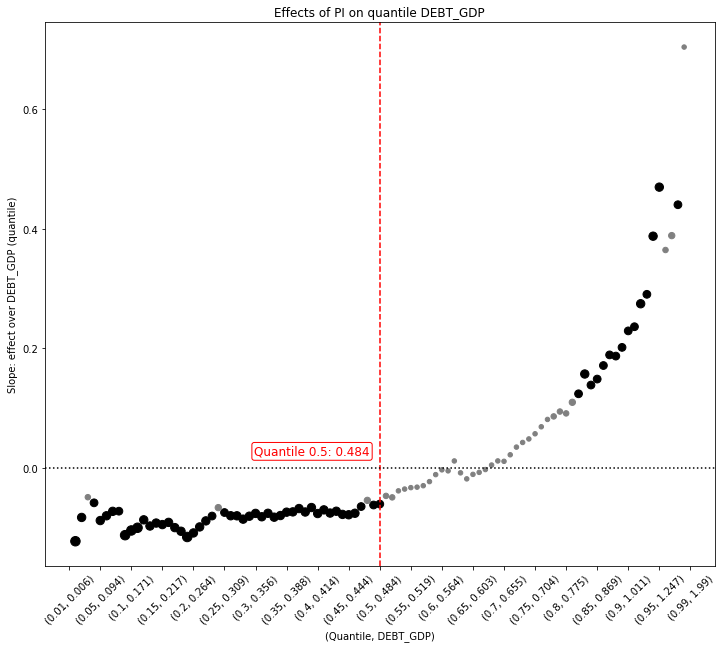

In [13]:
#PARAMETROS
# CONTROLES = ["0_SIN_CONTROL", "1_CON_ECUDEUD", "2_CON_ITODOS"]
CONTROLES = ["2_CON_ITODOS"]

# DEPENDIENTE   =  "DEBT_AFFORTABILITY"
# DEPENDIENTE   =  "IMP_RATE"
DEPENDIENTE   =  "DEBT_GDP" 
# DEPENDIENTE   =  "CREDITAV" 

INDEPENDIENTE = "PI"
# INDEPENDIENTE = "DEBT_AFFORTABILITY"
# INDEPENDIENTE   =  "CREDITAV" 
# INDEPENDIENTE = "HIGH_DEBT_PI"


for CONTROL in CONTROLES:
   # Create an empty DataFrame to store the results
    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    if INDEPENDIENTE in C_DEUDA:
        try:
            C_DEUDA_L.remove(f"{INDEPENDIENTE}_l1")
        except:
            None

    # Perform quantile regression for different quantiles
    for i in tqdm(rango_pct):

        qv = dff[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_SIN_CONTROL':
            # formula = f'DEBT_GDP ~ PI'
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI'
        
        elif  CONTROL == '1_CON_ECUDEUD':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + {formula_add(C_DEUDA_L)} + PI'
        
        elif  CONTROL == '2_CON_ITODOS':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'
            

        # Fit the quantile regression model
        model = smf.quantreg(formula, dff)
        result = model.fit(q=qs)

        # Extract relevant information and append to the DataFrame
        # slope = result.params[INDEPENDIENTE] + result.params["PI"]
        slope = result.params[INDEPENDIENTE]
        pvalue = result.pvalues[INDEPENDIENTE]

        # Calculate the lower and upper intervals
        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)


    ###################################################################################################################################################################
    # Assuming you have already created the result_df DataFrame with the results
    plt.figure(figsize=(12, 10))

    ############################################################################################
    #PLOT
    # plt.scatter(result_df['Quantile'], result_df['Lower'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
    # plt.scatter(result_df['Quantile'], result_df['Upper'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
    # for i in range(len(result_df)):
    #     plt.vlines(x=result_df['Quantile'].iloc[i], ymin=result_df['Lower'].iloc[i], ymax=result_df['Upper'].iloc[i], colors='gray')
    ############################################################################################
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', color='gray', label='p≥0.1', s = not_significant["pc"])

    ############################################################################################
    # LINES
    # Add a vertical line at x = threshold.Quantile with a label
    threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
    # threshold_v = result_df[(result_df.Solpe==result_df.Slope.max())].iloc[0]
    # threshold_v = result_df[(result_df["significative"]==1)].iloc[0]
    # threshold_v = result_df[(result_df["Slope"]>0)].iloc[0]
    threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
    plt.axvline(x=threshold['Quantile'], color='red', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, {DEPENDIENTE})')
    plt.ylabel(f'Slope: effect over {DEPENDIENTE} (quantile)')
    plt.title(f'Effects of {INDEPENDIENTE} on quantile {DEPENDIENTE}')

    # Annotate the vertical line with the value of threshold.Quantile_value
    plt.annotate(
        f"Quantile {threshold['Quantile']}: {threshold['Quantile_value']:.3f}",
        xy=(threshold['Quantile'], 0),  # Position of the label
        xytext=(-10, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='right',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='red',  # Text color
        fontsize=12,  # Text font size
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='red', facecolor='white')  # Label background
    )

    # Añadir puntos ficticios para la leyenda
    # for size, (lower, upper) in zip(labels, zip(bins[:-1], bins[1:])):
    #     plt.scatter([], [], s=size, label=f'{lower} ≤ p < {upper}', color='white', edgecolor='black')

    # plt.legend(scatterpoints=1, title="Rangos de p-value", bbox_to_anchor=(1, 1), loc='upper left')

    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # ymax, ymin = 1, -0.5
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility

    # plt.legend()
    # plt.grid(True)
    plt.grid(False)

    # if INF == 'PI_POR':
    #     plt.savefig(f"IMAGENES_DIR/{DEPENDIENTE}_{INDEPENDIENTE}_{INF}_{CONTROL}.jpeg", dpi = 200, bbox_inches='tight')

    # if INF != 'PI_POR':
    #     plt.savefig(f"IMAGENES_IV/{DEPENDIENTE}_{INDEPENDIENTE}_{INF}_{CONTROL}.jpeg", dpi = 200, bbox_inches='tight')

    plt.show()

## CANALES

In [17]:
ugo = pd.read_csv("INPUT/WEO_1990_2022_FR.csv")

In [18]:
ugo = ugo[["ifscode", "year", 
     "gdp_usd_g_a",	"gdp_usd_g_f0", "gdp_usd_g_f1", "gdp_usd_g_f2", "gdp_usd_g_f3",
     "exr_a", "exr_f0", "exr_f1", "exr_f2", "exr_f3"]]

In [19]:
ugo = ugo[["ifscode", "year", "gdp_usd_g_a", "exr_a"]]

In [20]:
ugo["exr_a"] = ugo.groupby(["ifscode"])["exr_a"].pct_change(1)

In [21]:
ugo.columns = ["WEO_CODE", "DATE", "GDPG", "DTC"]

In [22]:
dff["DH"] = dff["DEBT_GDP"].apply(lambda x: 1 if x>=0.62 else 0)
dff["DH_PI"] = dff["DH"]*dff["PI"]

In [23]:
dff = dff.merge(ugo, "left", ["WEO_CODE", "DATE"])

In [24]:
deepf = pd.read_excel("INPUT/Data_profundidad_financiera.xlsx")
deepf = deepf[["WEO_CODE", "DATE", "ka_open", "pnfs_nfs", "dom_debt_sh"]]

In [25]:
deepf.columns = [i.upper() for i in deepf.columns]

In [26]:
dff = dff.merge(deepf, "left", ["WEO_CODE", "DATE"])

In [27]:
dff

,COUNTRY_NAME,WEO_CODE,ISO3,DATE,REGION,LAC1,LAC2,DEBT_GDP,PI,DEBT_AFFORTABILITY,...,PRIM_BAL_GDP_l1,ER_DEP_l1,ER_DEP_VOL_l1,DH,DH_PI,GDPG,DTC,KA_OPEN,PNFS_NFS,DOM_DEBT_SH
0,United States of America (the),111,USA,1996,North America,0,0,0.411882,0.032175,0.078034,...,0.226908,0.000000,0.000000,0,0.0,0.053920,0.000000,1.000000,64.991982,NaN
1,United States of America (the),111,USA,1997,North America,0,0,0.435798,-0.015397,0.076724,...,0.192039,0.000000,0.000000,0,-0.0,0.058650,0.000000,1.000000,65.651711,NaN
2,United States of America (the),111,USA,1998,North America,0,0,0.459714,-0.003790,0.075415,...,0.157169,0.000000,0.000000,0,-0.0,0.056718,0.000000,1.000000,67.175171,NaN
3,United States of America (the),111,USA,1999,North America,0,0,0.483630,-0.021454,0.074106,...,0.122300,0.000000,0.000000,0,-0.0,0.055466,0.000000,1.000000,70.559998,NaN
4,United States of America (the),111,USA,2000,North America,0,0,0.507546,0.024407,0.072797,...,0.087431,0.000000,0.000000,0,0.0,0.059339,0.000000,1.000000,72.493301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4115,Romania,968,ROU,2018,Europe and Central Asia,0,0,0.361892,0.025655,0.046098,...,-0.017651,-0.003213,0.111574,0,0.0,0.141382,0.028129,1.000000,NaN,NaN
4116,Romania,968,ROU,2019,Europe and Central Asia,0,0,0.366294,-0.041609,0.039321,...,-0.014030,-0.026321,0.019793,0,-0.0,NaN,-0.065175,1.000000,NaN,NaN
4117,Romania,968,ROU,2020,Europe and Central Asia,0,0,0.493912,-0.213412,0.045907,...,-0.034259,0.076087,0.053712,0,-0.0,NaN,-0.001825,0.940168,NaN,NaN
4118,Romania,968,ROU,2021,Europe and Central Asia,0,0,0.511057,-0.085762,0.048173,...,-0.082505,-0.000008,0.053182,0,-0.0,NaN,0.025516,0.880336,NaN,NaN


In [29]:
result.params[INDEPENDIENTE]

-0.2800911811924949

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    DTC   Pseudo R-squared:            4.321e-06
Model:                       QuantReg   Bandwidth:                     0.02035
Method:                 Least Squares   Sparsity:                        6.655
Date:                Tue, 06 Feb 2024   No. Observations:                 4120
Time:                        11:02:45   Df Residuals:                     4116
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2252      0.013     17.629      0.000       0.200       0.250
DH_PI          0.4954      0.298      1.660      0.097      -0.090       1.080
PI            -0.3101      0.166     -1.864      0.062      -0.636       0.016
DH            -0.0172      0.022     -0.776      0.438      -0.061       0.026
==============================================================================
"""

In [76]:
dff["PNFS_NFS"] = dff["PNFS_NFS"]/100

  0%|          | 0/99 [00:00<?, ?it/s]

<ipython-input-80-b49094036ae7>:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
  1%|          | 1/99 [00:00<00:16,  5.92it/s]<ipython-input-80-b49094036ae7>:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
  2%|▏         | 2/99 [00:00<00:17,  5.42it/s]<ipython-input-80-b49094036ae7>:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, '

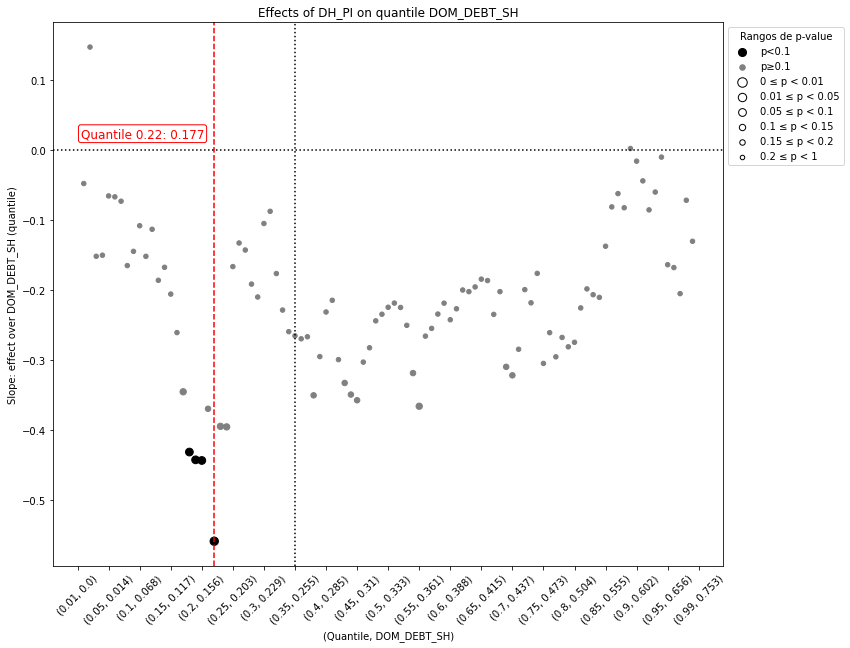

In [80]:
#PARAMETROS
# CONTROLES = ["0_SIN_CONTROL", "1_CON_ECUDEUD", "2_CON_ITODOS"]
# CONTROLES = ["2_CON_ITODOS"]

# DEPENDIENTE   =  "GDPG"
# DEPENDIENTE   =  "DTC"
# DEPENDIENTE   =  "PNFS_NFS"
# DEPENDIENTE   =  "KA_OPEN"
DEPENDIENTE   =  "DOM_DEBT_SH"

# DEPENDIENTE   =  "CREDITAV" 

INDEPENDIENTE = "DH_PI"
# INDEPENDIENTE = "DEBT_AFFORTABILITY"
# INDEPENDIENTE   =  "CREDITAV" 
# INDEPENDIENTE = "HIGH_DEBT_PI"


for CONTROL in CONTROLES:
   # Create an empty DataFrame to store the results
    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    # if INDEPENDIENTE in C_DEUDA:
    #     try:
    #         C_DEUDA_L.remove(f"{INDEPENDIENTE}_l1")
    #     except:
    #         None

    # Perform quantile regression for different quantiles
    for i in tqdm(rango_pct):

        qv = dff[DEPENDIENTE].quantile(i)
        qs = i

        # if CONTROL == '0_SIN_CONTROL':
        #     # formula = f'DEBT_GDP ~ PI'
        #     formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI'
        
        # elif  CONTROL == '1_CON_ECUDEUD':
        #     formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + {formula_add(C_DEUDA_L)} + PI'
        
        # elif  CONTROL == '2_CON_ITODOS':
        #     formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'


        # formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI  + DH + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1  + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN'
        formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI  + DH + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1  + WGI_GOV_IND + DEMOCRACY'

        # formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI  + DH + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1  + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN'


        # Fit the quantile regression model
        model = smf.quantreg(formula, dff)
        result = model.fit(q=qs)

        # Extract relevant information and append to the DataFrame
        # slope = result.params[INDEPENDIENTE] + result.params["PI"]
        slope = result.params[INDEPENDIENTE]
        pvalue = result.pvalues[INDEPENDIENTE]

        # Calculate the lower and upper intervals
        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)


    ###################################################################################################################################################################
    # Assuming you have already created the result_df DataFrame with the results
    plt.figure(figsize=(12, 10))

    ############################################################################################
    #PLOT
    # plt.scatter(result_df['Quantile'], result_df['Lower'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
    # plt.scatter(result_df['Quantile'], result_df['Upper'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
    # for i in range(len(result_df)):
    #     plt.vlines(x=result_df['Quantile'].iloc[i], ymin=result_df['Lower'].iloc[i], ymax=result_df['Upper'].iloc[i], colors='gray')
    ############################################################################################
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', color='gray', label='p≥0.1', s = not_significant["pc"])

    ############################################################################################
    # LINES
    # Add a vertical line at x = threshold.Quantile with a label
    threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
    # threshold_v = result_df[(result_df.Solpe==result_df.Slope.max())].iloc[0]
    # threshold_v = result_df[(result_df["significative"]==1)].iloc[0]
    # threshold_v = result_df[(result_df["Slope"]>0)].iloc[0]
    threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
    plt.axvline(x=threshold['Quantile'], color='red', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    # valor_cero = result_df[(result_df.Quantile_value>=0) & (result_df.Quantile_value<=0.01)].Quantile.iloc[0]
    # plt.axvline(x=valor_cero, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.35, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, {DEPENDIENTE})')
    plt.ylabel(f'Slope: effect over {DEPENDIENTE} (quantile)')
    plt.title(f'Effects of {INDEPENDIENTE} on quantile {DEPENDIENTE}')

    # Annotate the vertical line with the value of threshold.Quantile_value
    plt.annotate(
        f"Quantile {threshold['Quantile']}: {threshold['Quantile_value']:.3f}",
        xy=(threshold['Quantile'], 0),  # Position of the label
        xytext=(-10, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='right',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='red',  # Text color
        fontsize=12,  # Text font size
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='red', facecolor='white')  # Label background
    )

    # Añadir puntos ficticios para la leyenda
    for size, (lower, upper) in zip(labels, zip(bins[:-1], bins[1:])):
        plt.scatter([], [], s=size, label=f'{lower} ≤ p < {upper}', color='white', edgecolor='black')

    plt.legend(scatterpoints=1, title="Rangos de p-value", bbox_to_anchor=(1, 1), loc='upper left')

    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # ymax, ymin = 1, -0.5
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility

    # plt.legend()
    # plt.grid(True)
    plt.grid(False)

    # if INF == 'PI_POR':
    #     plt.savefig(f"IMAGENES_DIR/{DEPENDIENTE}_{INDEPENDIENTE}_{INF}_{CONTROL}.jpeg", dpi = 200, bbox_inches='tight')

    # if INF != 'PI_POR':
    #     plt.savefig(f"IMAGENES_IV/{DEPENDIENTE}_{INDEPENDIENTE}_{INF}_{CONTROL}.jpeg", dpi = 200, bbox_inches='tight')

    plt.show()

<AxesSubplot:>

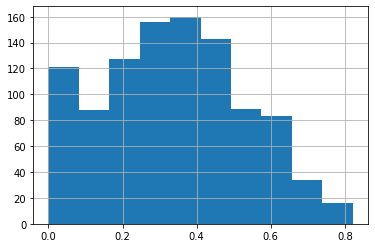

In [82]:
dff["DOM_DEBT_SH"].hist()

In [86]:
dff.to_stata("dbvf.dta")

Loop

  0%|          | 0/99 [00:00<?, ?it/s]

<ipython-input-48-a95390933300>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
  1%|          | 1/99 [00:00<00:21,  4.65it/s]<ipython-input-48-a95390933300>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
  2%|▏         | 2/99 [00:00<00:21,  4.45it/s]<ipython-input-48-a95390933300>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, '

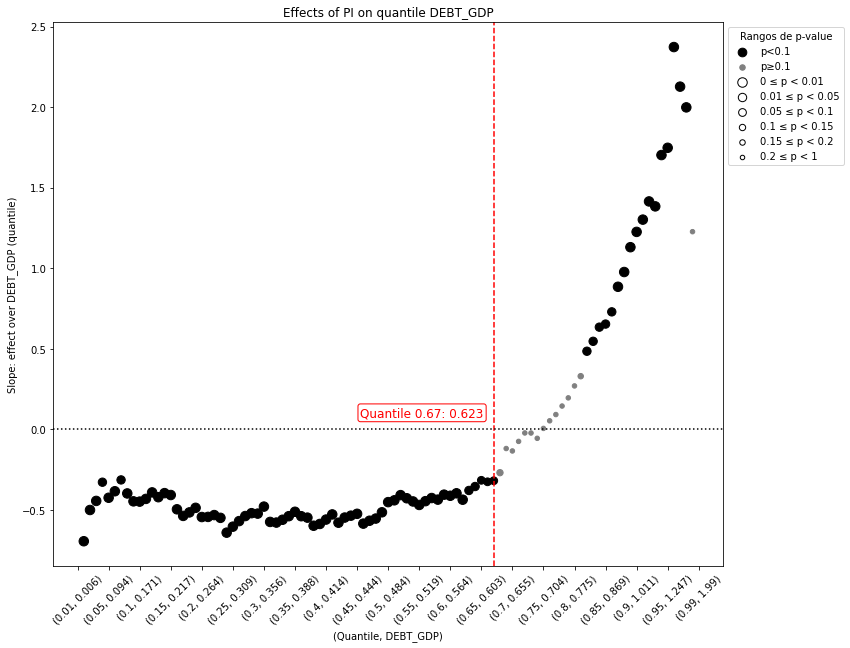

In [ ]:
#PARAMETROS
# CONTROLES = ["0_SIN_CONTROL", "1_CON_ECUDEUD", "2_CON_ITODOS"]
CONTROLES = ["2_CON_ITODOS"]

# DEPENDIENTE   =  "DEBT_AFFORTABILITY"
# DEPENDIENTE   =  "IMP_RATE"
DEPENDIENTE   =  "DEBT_GDP" 
# DEPENDIENTE   =  "CREDITAV" 

INDEPENDIENTE = "PI"
# INDEPENDIENTE = "DEBT_AFFORTABILITY"
# INDEPENDIENTE   =  "CREDITAV" 
# INDEPENDIENTE = "HIGH_DEBT_PI"


for CONTROL in CONTROLES:
   # Create an empty DataFrame to store the results
    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    if INDEPENDIENTE in C_DEUDA:
        try:
            C_DEUDA_L.remove(f"{INDEPENDIENTE}_l1")
        except:
            None

    # Perform quantile regression for different quantiles
    for i in tqdm(rango_pct):

        qv = dff[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_SIN_CONTROL':
            # formula = f'DEBT_GDP ~ PI'
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI'
        
        elif  CONTROL == '1_CON_ECUDEUD':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + {formula_add(C_DEUDA_L)} + PI'
        
        elif  CONTROL == '2_CON_ITODOS':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'
            

        # Fit the quantile regression model
        model = smf.quantreg(formula, dff)
        result = model.fit(q=qs)

        # Extract relevant information and append to the DataFrame
        slope = result.params[INDEPENDIENTE] + result.params["PI"]
        pvalue = result.pvalues[INDEPENDIENTE]

        # Calculate the lower and upper intervals
        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Slope': slope, 'Lower': lower, 'Upper': upper, "p-value": pvalue}, ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)


    ###################################################################################################################################################################
    # Assuming you have already created the result_df DataFrame with the results
    plt.figure(figsize=(12, 10))

    ############################################################################################
    #PLOT
    # plt.scatter(result_df['Quantile'], result_df['Lower'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
    # plt.scatter(result_df['Quantile'], result_df['Upper'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
    # for i in range(len(result_df)):
    #     plt.vlines(x=result_df['Quantile'].iloc[i], ymin=result_df['Lower'].iloc[i], ymax=result_df['Upper'].iloc[i], colors='gray')
    ############################################################################################
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', color='gray', label='p≥0.1', s = not_significant["pc"])

    ############################################################################################
    # LINES
    # Add a vertical line at x = threshold.Quantile with a label
    threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
    # threshold_v = result_df[(result_df.Solpe==result_df.Slope.max())].iloc[0]
    # threshold_v = result_df[(result_df["significative"]==1)].iloc[0]
    # threshold_v = result_df[(result_df["Slope"]>0)].iloc[0]
    threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
    plt.axvline(x=threshold['Quantile'], color='red', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, {DEPENDIENTE})')
    plt.ylabel(f'Slope: effect over {DEPENDIENTE} (quantile)')
    plt.title(f'Effects of {INDEPENDIENTE} on quantile {DEPENDIENTE}')

    # Annotate the vertical line with the value of threshold.Quantile_value
    plt.annotate(
        f"Quantile {threshold['Quantile']}: {threshold['Quantile_value']:.3f}",
        xy=(threshold['Quantile'], 0),  # Position of the label
        xytext=(-10, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='right',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='red',  # Text color
        fontsize=12,  # Text font size
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='red', facecolor='white')  # Label background
    )

    # Añadir puntos ficticios para la leyenda
    for size, (lower, upper) in zip(labels, zip(bins[:-1], bins[1:])):
        plt.scatter([], [], s=size, label=f'{lower} ≤ p < {upper}', color='white', edgecolor='black')

    plt.legend(scatterpoints=1, title="Rangos de p-value", bbox_to_anchor=(1, 1), loc='upper left')

    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # ymax, ymin = 1, -0.5
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility

    # plt.legend()
    # plt.grid(True)
    plt.grid(False)

    # if INF == 'PI_POR':
    #     plt.savefig(f"IMAGENES_DIR/{DEPENDIENTE}_{INDEPENDIENTE}_{INF}_{CONTROL}.jpeg", dpi = 200, bbox_inches='tight')

    # if INF != 'PI_POR':
    #     plt.savefig(f"IMAGENES_IV/{DEPENDIENTE}_{INDEPENDIENTE}_{INF}_{CONTROL}.jpeg", dpi = 200, bbox_inches='tight')

    plt.show()

## CANALES

In [ ]:
ugo = pd.read_csv("INPUT/WEO_1990_2022_FR.csv")

In [ ]:
ugo = ugo[["ifscode", "year", 
     "gdp_usd_g_a",	"gdp_usd_g_f0", "gdp_usd_g_f1", "gdp_usd_g_f2", "gdp_usd_g_f3",
     "exr_a", "exr_f0", "exr_f1", "exr_f2", "exr_f3"]]

In [ ]:
ugo = ugo[["ifscode", "year", "gdp_usd_g_a", "exr_a"]]

In [ ]:
ugo["exr_a"] = ugo.groupby(["ifscode"])["exr_a"].pct_change(1)

<ipython-input-65-c4c77610b91e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ugo["exr_a"] = ugo.groupby(["ifscode"])["exr_a"].pct_change(1)


In [13]:
i

0.01

<Figure size 1080x576 with 0 Axes>

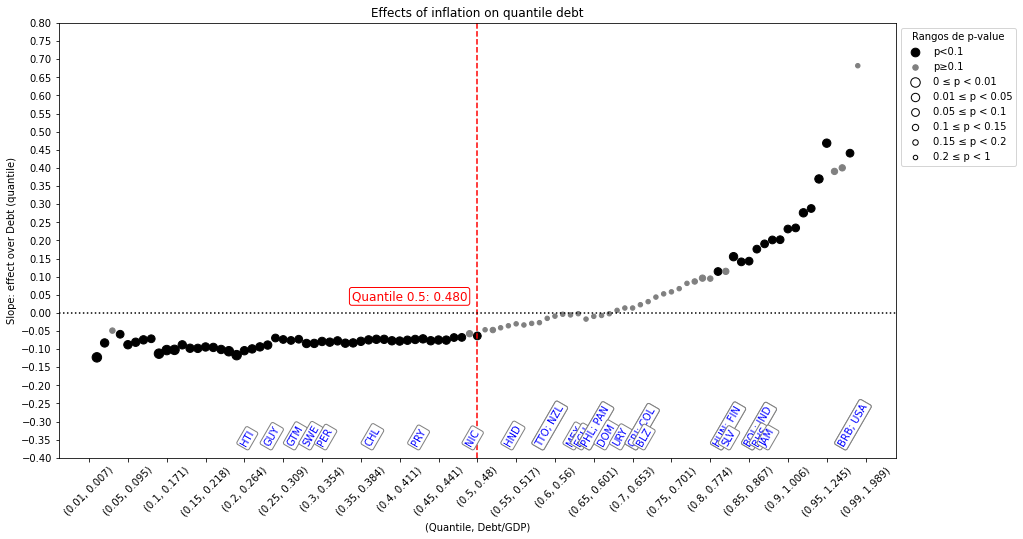

In [1034]:
# Assuming you have already created the result_df DataFrame with the results
plt.figure(figsize=(15, 8))

fig, ax1 = plt.subplots(figsize=(15, 8))

############################################################################################
#PLOT
# plt.scatter(result_df['Quantile'], result_df['Lower'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
# plt.scatter(result_df['Quantile'], result_df['Upper'], color = "gray", marker = "_", s = 80, edgecolor='black', linewidth=2)
# for i in range(len(result_df)):
#     plt.vlines(x=result_df['Quantile'].iloc[i], ymin=result_df['Lower'].iloc[i], ymax=result_df['Upper'].iloc[i], colors='gray')
############################################################################################
#SCATTER PLOT
bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
labels = [90, 70, 60, 40, 30, 20]
result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
significant = result_df[result_df['significative'] == 1]
not_significant = result_df[result_df['significative'] == 0]
plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', color='gray', label='p≥0.1', s = not_significant["pc"])

############################################################################################
# LINES
# Add a vertical line at x = threshold.Quantile with a label
threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
# threshold_v = result_df[(result_df["Slope"]>0)].iloc[0]
threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
plt.axvline(x=threshold['Quantile'], color='red', linestyle='--')
plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

############################################################################################
#LABELS/LEYENDAS
plt.xlabel('(Quantile, Debt/GDP)')
plt.ylabel('Slope: effect over Debt (quantile)')
plt.title('Effects of inflation on quantile debt')

# Annotate the vertical line with the value of threshold.Quantile_value
plt.annotate(
    f"Quantile {threshold['Quantile']}: {threshold['Quantile_value']:.3f}",
    xy=(threshold['Quantile'], 0),  # Position of the label
    xytext=(-10, 10),  # Offset for label placement (adjust as needed)
    textcoords='offset points',
    ha='right',  # Horizontal alignment of the label
    va='bottom',  # Vertical alignment of the label
    color='red',  # Text color
    fontsize=12,  # Text font size
    bbox=dict(boxstyle='round,pad=0.2', edgecolor='red', facecolor='white')  # Label background
)

# Añadir puntos ficticios para la leyenda
for size, (lower, upper) in zip(labels, zip(bins[:-1], bins[1:])):
    plt.scatter([], [], s=size, label=f'{lower} ≤ p < {upper}', color='white', edgecolor='black')

plt.legend(scatterpoints=1, title="Rangos de p-value", bbox_to_anchor=(1, 1), loc='upper left')


for quantile_value in promedios.Quantile:
    iso3_code =  '; '.join(list(promedios[promedios['Quantile'] == quantile_value]['ISO3'].values[:]))

    # plt.axvline(x=quantile_value, color='green', linestyle='--')
    plt.annotate(
        iso3_code,
        xy=(quantile_value, -0.4),  # Position of the label
        xytext=(10, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='left',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='blue',  # Text color
        fontsize=10,  # Text font size
        rotation = 60,
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white')  # Label background
    )


# for quantile_value in p1.Quantile:
#     iso3_code = p1[p1['Quantile'] == quantile_value]['ISO3'].values[0]
#     # plt.axvline(x=quantile_value, color='green', linestyle='--')
#     plt.annotate(
#         iso3_code,
#         xy=(quantile_value, -0.4),  # Position of the label
#         xytext=(10, 10),  # Offset for label placement (adjust as needed)
#         textcoords='offset points',
#         ha='left',  # Horizontal alignment of the label
#         va='bottom',  # Vertical alignment of the label
#         color='black',  # Text color
#         fontsize=8,  # Text font size
#         rotation = 60,
#         bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white')  # Label background
#     )

# for quantile_value in p2.Quantile:
#     iso3_code = p2[p2['Quantile'] == quantile_value]['ISO3'].values[0]
#     # plt.axvline(x=quantile_value, color='green', linestyle='--')
#     plt.annotate(
#         iso3_code,
#         xy=(quantile_value, -0.35),  # Position of the label
#         xytext=(10, 10),  # Offset for label placement (adjust as needed)
#         textcoords='offset points',
#         ha='left',  # Horizontal alignment of the label
#         va='bottom',  # Vertical alignment of the label
#         color='black',  # Text color
#         fontsize=8,  # Text font size
#         rotation = 60,
#         bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white')  # Label background
#     )



############################################################################################
# ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
# ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

ymax, ymin = 0.8, -0.4
plt.ylim(ymin, ymax)
plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
df_tick = result_df[result_df["Quantile"].isin(qsticks)]
custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


# plt.legend()
# plt.grid(True)
plt.grid(False)

plt.show()

In [1033]:
gr = dff[(dff["DATE"]>2021) & (dff["DATE"]<2023)]
promedios = gr.groupby(["ISO3"])["DEBT_GDP", "LAC1"].mean().reset_index()

LAC = list(dff[(dff.LAC1==1)].ISO3.unique())
OTHERS = ["NZL", "USA", "SWE", "FIN", "IND", "PAK", "PHL", "HUN"]

promedios = promedios[promedios['ISO3'].isin(OTHERS + LAC)]

# Function to find the closest Quantile_value
def find_closest_quantile_value(debt_gdp):
    return result_df.loc[(result_df['Quantile_value'] - debt_gdp).abs().idxmin(), 'Quantile_value']

# Add a new column 'Quantile_value' to lac_df based on closest Quantile_value
promedios['Quantile_value'] = promedios['DEBT_GDP'].apply(find_closest_quantile_value)
promedios = promedios.merge(result_df, "left", "Quantile_value").sort_values(by = "Quantile_value")

<ipython-input-1033-a97c8cd211a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  promedios = gr.groupby(["ISO3"])["DEBT_GDP", "LAC1"].mean().reset_index()


In [1013]:
p1 = promedios.drop_duplicates(["Quantile"], keep = "first")

In [1018]:
p2 = promedios.drop_duplicates(["Quantile"], keep = "last")
p2 = p2[~p2["ISO3"].isin(list(p1.ISO3))]

In [1035]:
promedios.to_excel("TABLA.xlsx")

<ipython-input-1035-202f30047374>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  promedios.to_excel("TABLA.xlsx")


In [ ]:
# https://budgetmodel.wharton.upenn.edu/issues/2021/10/21/can-inflation-offset-government-debt
# https://documents1.worldbank.org/curated/en/178761580308301016/pdf/Inflation-and-Public-Debt-Reversals-in-Advanced-Economies.pdf

In [ ]:
# rango_pct = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
# rango_pct = [0.1, 0.2, 0.8, 0.9]

In [ ]:
    # formula = f'DEBT_GDP ~ PI + {formula_add(dumies_c)} + {formula_add(dumies_y)}'

In [ ]:
    # dumies_c = pd.get_dummies(dff["ISO3"]).iloc[:, 1:]
    # dumies_y = pd.get_dummies(dff["DATE"]).iloc[:, 1:]; dumies_y.columns = [f"Y{round(i)}" for i in dumies_y.columns]
    # dff = pd.concat([dff, dumies_c, dumies_y], axis = 1)

In [299]:
#PASOS
# 1. INCLUIR CONTROLES (DEUDA + INSTITUCIONALES)

# HIPOTESIS 

# 1. incluir controles + componentes deuda (paper Paolo Mauro de sorpresas a ver como lo hacen ellos - 2023)


# Canal de transmisciones: tasas de interes, marco institucional fuerte --> reglas fiscales, depreciaciones reales por inflación
# ¿Paises de deuda baja son los más responsables? ¿Politica contraciclicas? --> RTA: FISCAL REACTION FUNCTION

La \textbf{ecuación de estimación de la regresión cuantílica} se representa de la siguiente manera:

\begin{equation}
Q_\tau(y | X) = X\beta_\tau
\end{equation}

Dónde:

- \( Q_\tau(y | X) \) es el cuantil \( \tau \) de la variable dependiente \( y \) condicionada a las variables independientes \( X \).
- \( \beta_\tau \) son los coeficientes de regresión cuantílica que estimamos.

\textbf{Explicación intuitiva:}

La regresión cuantílica es una técnica estadística que se utiliza cuando estamos interesados en entender cómo diferentes variables independientes (representadas por \( X \)) afectan los diferentes cuantiles de una variable dependiente \( y \). En otras palabras, no estamos interesados en la estimación de la media o el valor esperado de \( y \), como en la regresión lineal tradicional, sino en cómo las variables \( X \) influyen en los valores extremos o en los cuantiles específicos de \( y \).

La función objetivo que se minimiza en la regresión cuantílica es:

\begin{equation}
\sum_{i: y_i \geq X_i\beta_\tau} \tau|y_i - X_i\beta_\tau| + \sum_{i: y_i < X_i\beta_\tau} (1-\tau)|y_i - X_i\beta_\tau|
\end{equation}

Esta ecuación busca minimizar la suma ponderada de las diferencias entre las observaciones y sus valores previstos por el modelo. Las ponderaciones dependen del cuantil \( \tau \) que estás tratando de estimar. Por ejemplo, si \( \tau = 0.5 \) (mediana), la regresión cuantílica reduce a la regresión de la mediana absoluta.


### Estimaciones con regresiones percentilicas: Bootstrapp

In [300]:
# def bootstrap(data, formula, repetitions, proportion, percentile):
#     """
#     data: DataFrame con los datos.
#     formula: Fórmula del modelo.
#     repetitions: Número de repeticiones de bootstrap.
#     proportion: Proporción de datos a usar en cada iteración (0 < proportion <= 1).
#     """
#     # Lista para guardar los resultados y coeficientes
#     # results = []
#     coefficients = []

#     # Número de observaciones a extraer en cada muestra
#     n_sample = int(len(data) * proportion)

#     for _ in range(repetitions):
#         # Extrae una muestra aleatoria de los datos
#         sample = data.sample(n_sample, replace=True)

#         # Ajusta el modelo a la muestra
#         model = smf.quantreg(formula, sample)
#         result = model.fit(q=percentile)  # Asumiendo que qs está definido previamente o es un argumento global

#         # Guarda el resultado y coeficientes en las listas
#         # results.append(result)
#         coefficients.append(result.params['PI'])

#     # Convierte los coeficientes a un DataFrame
#     coef_df = pd.DataFrame(coefficients)

#     # Calcula el promedio e intervalos
#     coef_mean = coef_df.mean()
#     coef_lower = coef_df.quantile(0.025)
#     coef_upper = coef_df.quantile(0.975)

#     return coef_mean, coef_lower, coef_upper


In [301]:
# # Create an empty DataFrame to store the results
# result_df = pd.DataFrame(columns=['Quantile', 'Quantile_value','Intercept', 'Slope'])
# # rango_pct = np.arange(0.01, 1, 0.05)
# rango_pct = [0.1, 0.2, 0.8, 0.9]
# rep = 1000

# # Perform quantile regression for different quantiles
# for i in rango_pct:
#     # dumies_c = pd.get_dummies(dff["ISO3"]).iloc[:, 1:]
#     # dumies_y = pd.get_dummies(dff["DATE"]).iloc[:, 1:]; dumies_y.columns = [f"Y{round(i)}" for i in dumies_y.columns]
#     # dff = pd.concat([dff, dumies_c, dumies_y], axis = 1)

#     qv = dff['DEBT_GDP'].quantile(i)
#     qs = i
#     # formula = f'DEBT_GDP ~ PI + {formula_add(dumies_c)} + {formula_add(dumies_y)}'
#     formula = f'DEBT_GDP ~ PI'

#     # Fit the quantile regression model
#     model = bootstrap(dff, formula, rep, 0.9,i)

#     # Extract relevant information and append to the DataFrame
#     intercept = np.nan
#     slope = model[0]

#     # Calculate the lower and upper intervals
#     lower = model[1]
#     upper = model[2]

#     result_df = result_df.append({'Quantile': qs, 'Quantile_value': qv, 'Intercept': intercept, 'Slope': slope, 'Lower': lower, 'Upper': upper}, ignore_index=True)

# result_df["Quantile"] = round(result_df["Quantile"], 2)

In [302]:
# # Parameters
# # qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
# df_tick = result_df[result_df["Quantile"].isin(qsticks)]
# # threshold_v = result_df[result_df["Slope"]>0].iloc[0]

# # Assuming you have already created the result_df DataFrame with the results
# plt.figure(figsize=(15, 8))
# plt.scatter(result_df['Quantile'], result_df['Slope'], marker='o', color='blue')
# plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
# plt.xlabel('(Quantile, Debt level)')
# plt.ylabel('Slope: effect over Debt (quantile)')
# plt.title('Effects of inflation on quantile debt')

# # plt.axvline(x=, color='red', linestyle='--', label=f"{threshold.Quantile_value}")


# # Add a vertical line at x = threshold.Quantile with a label
# threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
# plt.axvline(x=threshold['Quantile'], color='red', linestyle='--')

# # Annotate the vertical line with the value of threshold.Quantile_value
# plt.annotate(
#     f"Quantile {threshold['Quantile']}: {threshold['Quantile_value']:.3f}",
#     xy=(threshold['Quantile'], 0),  # Position of the label
#     xytext=(-10, 10),  # Offset for label placement (adjust as needed)
#     textcoords='offset points',
#     ha='right',  # Horizontal alignment of the label
#     va='bottom',  # Vertical alignment of the label
#     color='red',  # Text color
#     fontsize=12,  # Text font size
#     bbox=dict(boxstyle='round,pad=0.2', edgecolor='red', facecolor='white')  # Label background
# )

# # INTERVALO INFERIOR
# plt.scatter(result_df['Quantile'], result_df['Lower'],
#     color = "black", marker = "_", s = 80, edgecolor='black', linewidth=2)

# # INTERVALO SUPERIOR
# plt.scatter(result_df['Quantile'], result_df['Upper'],
#     color = "black", marker = "_", s = 80, edgecolor='black', linewidth=2)

# # LÍNEAS HORIZONTALES
# for i in range(len(result_df)):
#     plt.vlines(x=result_df['Quantile'].iloc[i], ymin=result_df['Lower'].iloc[i], ymax=result_df['Upper'].iloc[i], colors='black')

# plt.ylim(-0.8,0.8)

# # Create custom x-axis ticks with labels that include both 'Quantile' and 'Quantile_value'
# custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]

# # Set the custom x-axis ticks
# # plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility
# plt.yticks(np.arange(-0.8, 1, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

# plt.grid(True)
# plt.show()

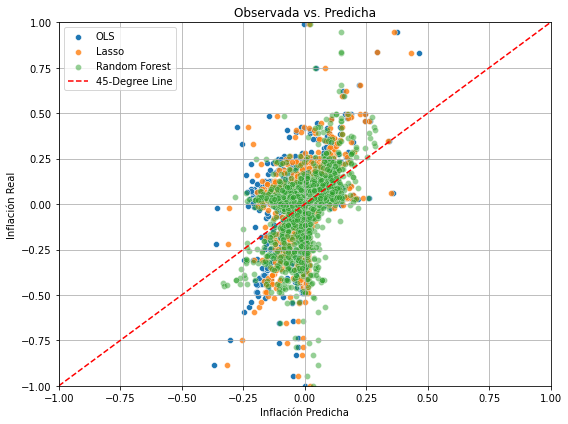

In [ ]:
# Extract the actual and predicted values
# actual_values = inf_panel['CPI_PORCENTAJE']

# # Create a plot
# plt.figure(figsize=(8, 6))

# # Scatterplot for OLS
# sns.scatterplot(y=actual_values, x=y_ols, label='OLS', alpha=1)
# sns.scatterplot(y=actual_values, x=y_lasso.values, label='Lasso', alpha=0.8)
# # sns.scatterplot(y=actual_values, x=y_ridge.values, label='Ridge', alpha=0.6)
# sns.scatterplot(y=actual_values, x=y_rf, label='Random Forest', alpha=0.5)

# # Add the 45-degree line
# plt.plot([-1, 1], [-1, 1], linestyle='--', color='red', label='45-Degree Line')

# # Customize the plot
# plt.title('Observada vs. Predicha')
# plt.xlabel('Inflación Predicha')
# plt.ylabel('Inflación Real')
# plt.legend()

# plt.ylim(-1, 1)
# plt.xlim(-1, 1)

# # Show the plot
# plt.grid(True)
# plt.tight_layout()
# plt.show()



# # Create a plot
# plt.figure(figsize=(8, 6))

# # Scatterplot for OLS
# sns.kdeplot(actual_values, label='Actual', alpha=1, color = "black")
# sns.kdeplot(y_ols, label='OLS', alpha=1, color = "blue")
# sns.kdeplot(y_rf, label='RF', alpha=1)
# # sns.kdeplot(y_lasso, label='OLS', alpha=1)

# # Customize the plot
# plt.title('Observada vs. Predicha')
# plt.xlabel('Inflación Predicha')
# plt.ylabel('Inflación Real')
# plt.legend()

# plt.ylim(0, 20)
# plt.xlim(-1, 1)

# # Show the plot
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(19, 6))